<a href="https://colab.research.google.com/github/veager/VeNote-Natural-language-processing/blob/main/tutorials/03_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Word2Vec

In [ ]:
# !pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

# import os
# assert os.environ['COLAB_TPU_ADDR']

# TPU_Path = 'grpc://'+os.environ['COLAB_TPU_ADDR']
# print('TPU Address:', TPU_Path)

# import torch
# import torch_xla
# import torch_xla.core.xla_model as xm

# device = xm.xla_device()

In [ ]:
!nvidia-smi

Sun May 22 09:31:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

use_gpu = torch.cuda.is_available()

if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

if device.type == 'cuda':
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.get_device_name(0))

cuda
True
1
0
Tesla T4


# 1. Skip-Gram

加载语料数据

In [ ]:
import nltk

import numpy as np
import pandas as pd

from collections import Counter

In [ ]:
nltk.download('brown')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

加载语料库

In [ ]:
# 加载语料库
from nltk.corpus import brown, stopwords
from nltk.tokenize import word_tokenize

# 加载 brown new 语料
# brown.categories()
# tokens = brown.words(categories='news')


import zipfile
z = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/StudyNotes/NLP/text8.zip', 'r')
print('zip files:', z.namelist())
content = z.read('text8/text8.train.txt').decode("utf-8")
z.close()
print('text sample:', content[:100])

# 分词
tokens = word_tokenize(content)
print(len(tokens))

zip files: ['text8/', 'text8/text8.dev.txt', 'text8/text8.test.txt', 'text8/text8.train.txt']
text sample: anarchism originated as a term of abuse first used against early working class radicals including th
15307013


In [ ]:
# 转为小写
tokens = [w.lower() for w in tokens]

# 加载停词
stop_words = stopwords.words('english')
print(stop_words)

# 过滤停词
tokens = [w for w in tokens if w not in stop_words]

# 过滤标点符号
import re
tokens = list(filter(lambda w : re.match(r'[a-zA-Z0-9\s]', w), tokens))

print(len(tokens))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

239849


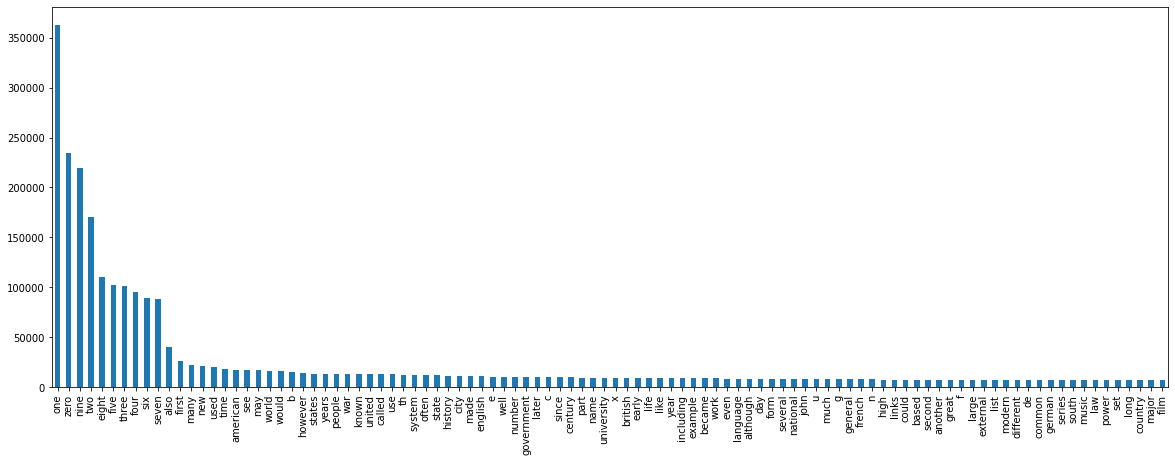

In [ ]:
# 统计频数
counter = Counter(tokens)
print(len(set(tokens)))

freq = dict(counter)
freq = dict(counter.most_common(100))   # 展示前 100 频数的词
pd.Series(freq).plot(figsize=(20, 7), kind='bar')

In [ ]:
# 参数 最大词典数
MAX_VOCAB_SIZE = 10000

vocab_dict = dict(Counter(tokens).most_common(MAX_VOCAB_SIZE - 1))        # 得到单词字典表，key是单词，value是频数
vocab_dict['<UNK>'] = len(tokens) - np.sum(list(vocab_dict.values()))     # 把不常用的单词都编码为"<UNK>"

print(vocab_dict)

word_to_ix = {word: i for i, word in enumerate(vocab_dict.keys())}
ix_to_word = {i: word for i, word in enumerate(vocab_dict.keys())}

{'one': 363077, 'zero': 234010, 'nine': 219583, 'two': 170527, 'eight': 110358, 'five': 102330, 'three': 101679, 'four': 95710, 'six': 89549, 'seven': 88376, 'also': 40020, 'first': 25760, 'many': 21810, 'new': 21235, 'used': 20455, 'time': 18568, 'american': 17548, 'see': 17453, 'may': 17252, 'world': 16099, 'would': 15611, 'b': 14783, 'however': 14351, 'states': 13412, 'years': 13318, 'people': 13304, 'war': 13167, 'known': 13067, 'united': 12965, 'called': 12716, 'use': 12697, 'th': 12126, 'system': 11809, 'often': 11774, 'state': 11578, 'history': 11517, 'city': 10844, 'made': 10604, 'english': 10582, 'e': 10455, 'well': 10389, 'number': 10282, 'government': 10125, 'later': 9852, 'c': 9677, 'since': 9664, 'century': 9649, 'part': 9533, 'name': 9526, 'university': 9251, 'x': 9189, 'british': 9146, 'early': 9129, 'life': 9063, 'like': 8881, 'year': 8799, 'including': 8694, 'example': 8689, 'became': 8613, 'work': 8599, 'even': 8563, 'language': 8550, 'although': 8386, 'day': 8345, 'f

In [ ]:
# # 词典
# N_TOKENS = len(tokens)
# N_VOCAB = len(vocab)
# print(N_TOKENS, N_VOCAB)

# N_GRAMS = 3

# from nltk.util import ngrams

# n_grams = ngrams(tokens, n=2 * N_GRAMS + 1,
#     pad_left=True, pad_right=True, left_pad_symbol='<UNK>', right_pad_symbol='<UNK>')
# n_grams = list(n_grams)[N_GRAMS: -N_GRAMS]

# list(n_grams)[:3]
# len(n_grams)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.data.dataloader import default_collate

class WordEmbeddingDataset(Dataset):
    def __init__(self, tokens, word_to_ix, n_grams):

        super(WordEmbeddingDataset, self).__init__()    #通过父类初始化模型，然后重写两个方法

        self.text_encoded = [word_to_ix.get(word, word_to_ix['<UNK>']) for word in tokens]   # 把单词数字化表示。如果不在词典中，也表示为unk
        self.text_encoded = torch.LongTensor(self.text_encoded)     # nn.Embedding 需要传入 LongTensor 类型
        # self.word_to_ix = word_to_ix
        self.n_grams = n_grams
        # self.word_freqs = torch.Tensor(word_freqs)

    def __len__(self):
        return len(self.text_encoded)   # 返回所有单词的总数，即item的总数

    def __getitem__(self, idx):

        center_words = self.text_encoded[idx] # 取得中心词

        pos_indices = list(range(idx - self.n_grams, idx)) + list(range(idx + 1, idx + self.n_grams + 1))     # 先取得中心左右各 n_grams 个词的索引
        pos_indices = [i % len(self.text_encoded) for i in pos_indices]     # 为了避免索引越界，所以进行取余处理
        context_words = self.text_encoded[pos_indices]

        return context_words, center_words


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, context_idxs, center_idxs):
        center_embeds = self.center_embeddings(center_idxs)
        center_embeds = center_embeds.unsqueeze(2)
        # print(embeds.size())

        context_embeds = self.context_embeddings(context_idxs)
        # print(context_embeds.size(), center_embeds.size())
        context_dot = torch.bmm(context_embeds, center_embeds)
        # print(context_dot.size())
        context_dot = context_dot.squeeze(2)
        # print(context_dot.size())

        log_probs = F.log_softmax(context_dot, dim=1)
        loss = -log_probs.sum(1)
        # print(loss.size())
        return loss

    def input_embedding(self):
        try:
            embed_vec = self.center_embeddings.weight.detach().numpy()
        except:
            embed_vec = self.center_embeddings.weight.detach().cpu().numpy()
        return embed_vec

In [ ]:
import time

import torch.optim as optim


N_GRAMS = 3   # 3 words to the left, 3 to the right
CONTENT_SIZE = N_GRAMS * 2

EMBEDDING_DIM = 128

BATCH_SIZE = 2048*2
N_EPOCH = 1

dataset = WordEmbeddingDataset(tokens, word_to_ix, n_grams=N_GRAMS)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

model = NGramLanguageModeler(MAX_VOCAB_SIZE, EMBEDDING_DIM, CONTENT_SIZE)
# 获取损失函数、优化器和模型
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

losses = []

for epoch in range(N_EPOCH):

    time_start = time.perf_counter()

    total_loss = 0

    for i, (context_idxs, center_idxs) in enumerate(dataloader):

        optimizer.zero_grad()

        loss = model(context_idxs, center_idxs).mean()
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    print(epoch+1, ':',
          round(total_loss,5),
          round(time.perf_counter()-time_start, 5)
    )

    losses.append(total_loss)

1 : 127193.92929 319.7363


In [ ]:
# embedding_weights_1 = model.input_embedding()[1]
# embedding_weights_2 = model.center_embeddings(torch.LongTensor(1))

# print(embedding_weights_1 - embedding_weights_2)

In [ ]:
from scipy.spatial.distance import cosine

embedding_weights = model.input_embedding()

def find_nearest(word):
    index = word_to_ix[word]
    embedding = embedding_weights[index]
    cos_dis = np.array([cosine(e, embedding) for e in embedding_weights])
    return [ix_to_word[i] for i in cos_dis.argsort()[:10]]

for word in ["two", "america", "man", "computer"]:
    print(word, find_nearest(word))

two ['two', 'fever', 'raiders', 'heated', 'restrictions', 'prayer', 'spiritual', 'covenant', 'kept', 'lack']
america ['america', 'dada', 'paint', 'trace', 'autobiography', 'tank', 'clerk', 'violent', 'turns', 'flew']
man ['man', 'forward', 'mobility', 'indus', 'windows', 'adapted', 'perspectives', 'culminating', 'slowly', 'north']
computer ['computer', 'grammy', 'alcoholism', 'charlton', 'statistics', 'weather', 'riemann', 'wired', 'perpetual', 'theologians']
